## Description du dataset

Le dataset **Online Retail** est un jeu de données classique utilisé pour explorer les ventes, analyser les clients (segmentation RFM),
ou encore la détection de comportements d'achat. 

INFORMATIONS:
- **Nom**: Online Retail
- **Source**: UCI Machine Learning Repository
- **Taille**: 541 910 transaction
- **Période**: Décembre 2010 à décembre 2011
- **Pays principal**: Royaume-Uni (mais inclut aussi d'autres pays)

DESCRIPTION DES VARIABLES:
- **InvoiceNo**: Numéro de facture (chaine de caractères). Commence par 'C' si c'est une **annulation**
- **StockCode**: Code produit unique.
- **Description**: Nom du produit
- **Quantity**: Quantité achetée. Peut etre **négatif** en cas de retour.
- **InvoiceDate**: Date et heure de la commande.
- **Unitprice**: Prix unitaire (en livres sterling).
- **CustomerID**: Identifiant unique du client (souvent manquant).
- **Country**: Pays du client

## Objectif et métrique

- **Objectif du projet:** Faire une **segmentation RFM** sur la clientèle de cette entreprise 

    - **R** --> Récence (Nombre de jours depuis la dernière commande)
    - **F** --> Fréquence (Nombre total de commandes de décembre 2010 à décembre 2011)
    - **M** --> Montant (montant total dépensé)

    Le but est d'identifier:
    - Les **plus fidèles**,
    - Les **plus rentables**, 
    - Ceux à **réactiver**,
    - Ceux qui **risquent de partir**

- **Métrique:** Comme il s'agit d'un apprentissage non-supervisé (clustering), nous voulons juste minimiser **l'inertia** (variance) entre 
    les points d'un cluster.


## Data cleaning et feature engineering

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Valeurs manquantes
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

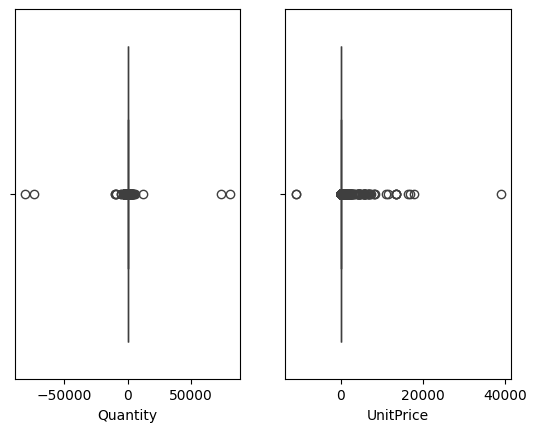

In [6]:
# outliers sur les quantités et les prix unitaires
cols = ['', 'Quantity', 'UnitPrice']

plt.figure()

for i in range (1, 3):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data, x=data[cols[i]])
plt.show()

In [7]:
# Verifier les valeur = 0 dans UnitPrice et Quantity

print('Quantités = 0:', (data['Quantity'] == 0).sum())
print('Prix Unitaires = 0:', (data['UnitPrice'] == 0.00).sum())

Quantités = 0: 0
Prix Unitaires = 0: 2515


In [8]:
# Remplacer les valeurs = 0 des prix unitaires par le prix unitaire du produit concerné

# Calculer le prix unitaire moyen (hors zéros) par produit
prix_moyens = data[data['UnitPrice'] > 0].groupby('StockCode')['UnitPrice'].mean() 

# Fonction de remplacement
def correct_unitprice(row):
    if row['UnitPrice'] == 0:
        return prix_moyens.get(row['StockCode'], 0) # retourne 0 si on trouve rien
    else:
        return row['UnitPrice']
    

# Application de la fonction
data['UnitPrice'] = data.apply(correct_unitprice, axis=1)


# verification 
print('Nombre de prix unitaires = 0 après remplacement:', (data['UnitPrice'] == 0).sum())

Nombre de prix unitaires = 0 après remplacement: 134


In [9]:
# Fonction de remplacement
def correct_unitprice1(row):
    if row['UnitPrice'] < 1001:
        return prix_moyens.get(row['StockCode'], 0) # retourne 0 si on trouve rien
    else:
        return row['UnitPrice']

# Application de la fonction
data['UnitPrice'] = data.apply(correct_unitprice1, axis=1)

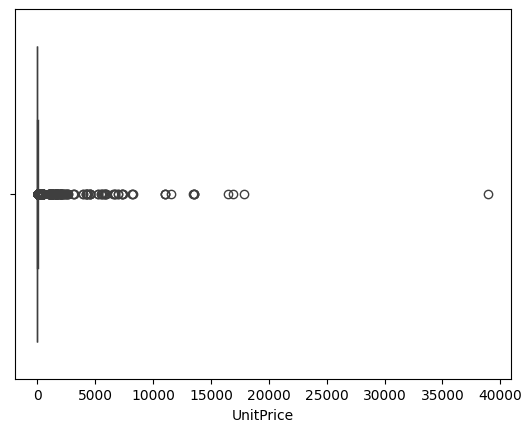

In [10]:
# Verification de unitprice
sns.boxplot(data=data, x=data['UnitPrice'])
plt.show()

In [11]:
# Suppression des lignes dont le prix unitaire est nul
data = data[data['UnitPrice'] > 0]
print('Nombre de prix unitaires = 0 après suppression:', (data['UnitPrice'] == 0).sum())

Nombre de prix unitaires = 0 après suppression: 0


In [12]:
# Nombre de produits
longueur = len(data.Description.unique())
print(f'Nombre de produits:{longueur}')

Nombre de produits:4217


Nous avons choisi de supprimer les lignes dans lesquelles il n'ya pas d'identifiant unique du client car étant dans le cadre d'une 
segmentation de la clientèle, ces lignes n'ont pas de racine solide (identifiant unique)

In [13]:
# Supprimer les lignes avec des valeurs manquantes sur l'identité des clients
df = data.dropna(subset=['CustomerID'])
df.shape

(406829, 8)

In [14]:
# filtrer les retours
df = df[df['Quantity'] > 0]

In [15]:
# Gestion des outliers
df = df[df['Quantity'] < 50]
#df = df[df['UnitPrice'] < 1001]

In [16]:
df.shape

(385420, 8)

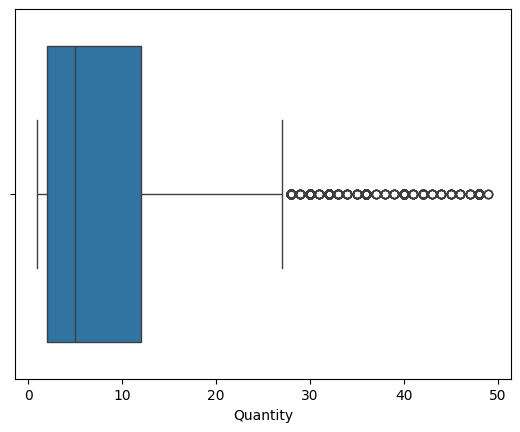

In [17]:
# Verification de quantity
sns.boxplot(data=df, x=df['Quantity'])
plt.show()

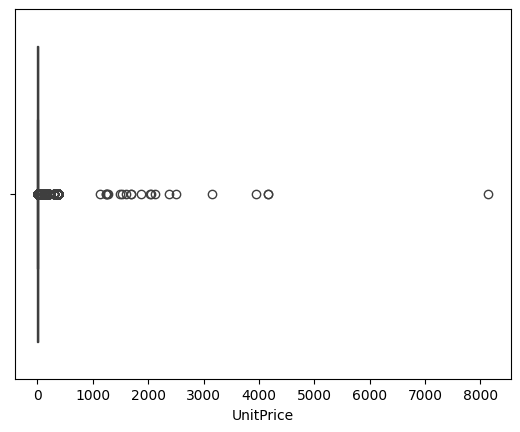

In [18]:
# Verification de UnitPrice
sns.boxplot(data=df, x=df['UnitPrice'])
plt.show()

In [19]:
# Création des variables

# Depense pour chaque commande
df ['Spend'] = df['Quantity'] * df['UnitPrice']

# Variable 'Montant'
m = df.groupby('CustomerID')['Spend'].sum().reset_index()
m.head()

,CustomerID,Spend
0,12347.0,5200.629284
1,12348.0,604.829139
2,12349.0,1739.545107
3,12350.0,400.940960
4,12352.0,3052.858914


In [20]:
# variable 'Frequence'
f = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
f.head()

,CustomerID,InvoiceNo
0,12347.0,181
1,12348.0,12
2,12349.0,73
3,12350.0,17
4,12352.0,85


In [21]:
# variable 'Récence'   

# Définition d'une date de référence (1 jour après la dernière commande du dataset)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Grouper par client et calculer la récence
r = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (reference_date - x.max()).days}).reset_index()

r.head()

,CustomerID,InvoiceDate
0,12347.0,2
1,12348.0,75
2,12349.0,19
3,12350.0,310
4,12352.0,36


In [22]:
# Jointure pour la construction du dataset final
rf = pd.merge(left=r, right=f)
rfm = pd.merge(left=rf, right=m)
rfm.columns = ['idClient', 'récence', 'fréquence', 'montant']
rfm.head()

,idClient,récence,fréquence,montant
0,12347.0,2,181,5200.629284
1,12348.0,75,12,604.829139
2,12349.0,19,73,1739.545107
3,12350.0,310,17,400.940960
4,12352.0,36,85,3052.858914


In [23]:
print('Nombre de récence < ou = 0:', (rfm['récence'] <= 0).sum())

Nombre de récence < ou = 0: 0


In [24]:
# Tranformer les colonnes en entiers
columns = ['récence', 'fréquence']
for col in columns:
    rfm[col] = rfm[col].round().astype(int)

rfm.head()

,idClient,récence,fréquence,montant
0,12347.0,2,181,5200.629284
1,12348.0,75,12,604.829139
2,12349.0,19,73,1739.545107
3,12350.0,310,17,400.940960
4,12352.0,36,85,3052.858914


## EDA (Exploratory Data Analysis)

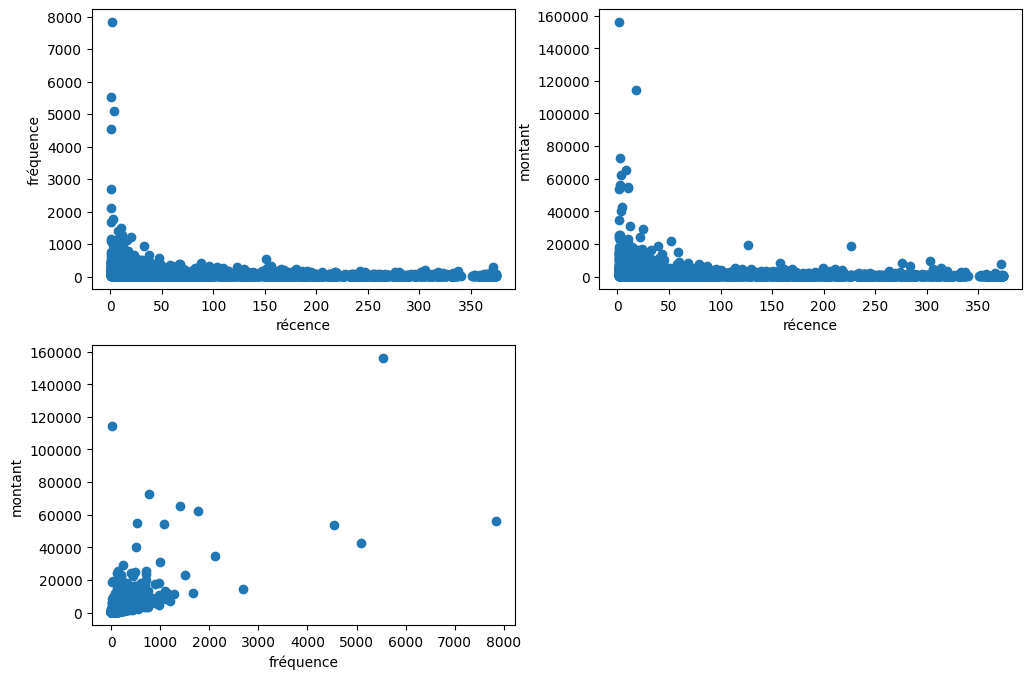

In [25]:
# Nuages de points
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(rfm['récence'], rfm['fréquence'])
plt.xlabel('récence')
plt.ylabel('fréquence')

plt.subplot(2, 2, 2)
plt.scatter(rfm['récence'], rfm['montant'])
plt.xlabel('récence')
plt.ylabel('montant')

plt.subplot(2, 2, 3)
plt.scatter(rfm['fréquence'], rfm['montant'])
plt.xlabel('fréquence')
plt.ylabel('montant')

plt.show()

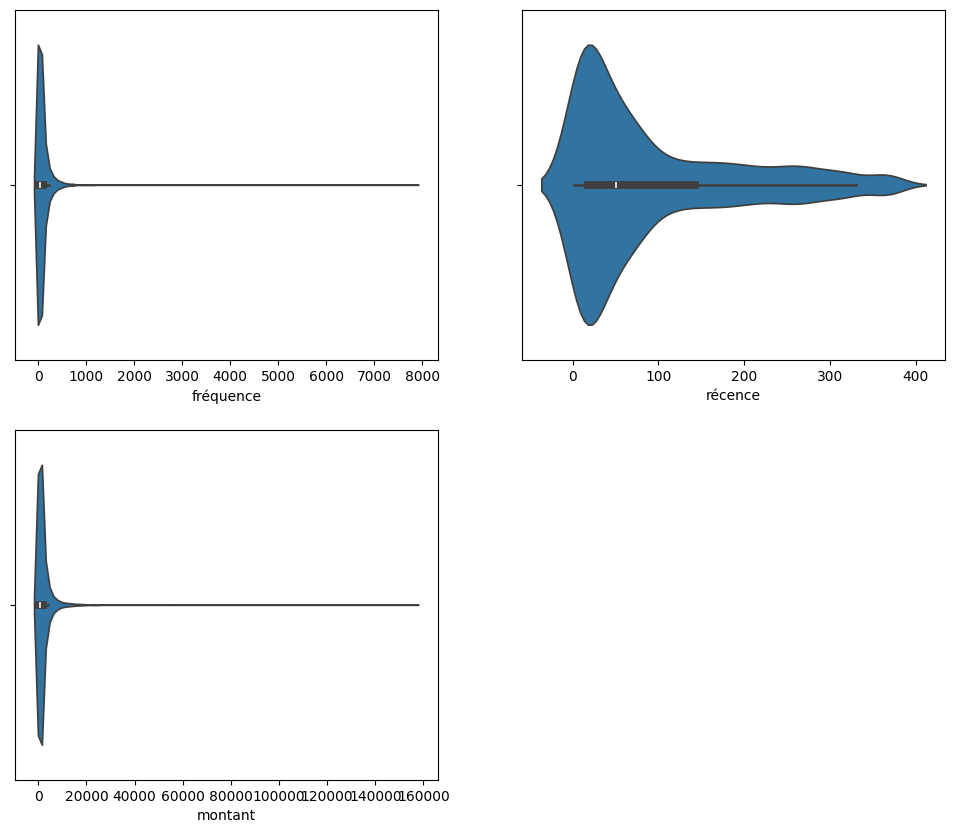

In [26]:
# Visualisation des outliers
cols = ['', 'fréquence', 'récence', 'montant']

plt.figure(figsize=(12, 10))

for i in range (1, 4):
    plt.subplot(2, 2, i)
    sns.violinplot(data=rfm, x=rfm[cols[i]])
plt.show()

In [27]:
rfm.head()

,idClient,récence,fréquence,montant
0,12347.0,2,181,5200.629284
1,12348.0,75,12,604.829139
2,12349.0,19,73,1739.545107
3,12350.0,310,17,400.940960
4,12352.0,36,85,3052.858914


In [28]:
# Normalisation des données 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

rfm_scaled = scaler.fit_transform(rfm)

In [29]:
# verification des dimensions
rfm_scaled.shape

(4267, 4)

In [30]:
# affectation des colonnes normalisées aux axes pour la visualisation
x = rfm_scaled[:, 1]
y = rfm_scaled[:, 2]
z = rfm_scaled[:, 3]

### Visualisation 3D des clients selon les trois facteurs Recense, Frequence et Montant

In [31]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d( 
    x= x.flatten(),
    y= y.flatten(),
    z= z.flatten(),
    mode='markers',
    marker=dict(
        size=5,
        color=y.flatten(),                
        colorscale=[
            [0.0, 'yellow'],
            [0.5, 'white'],
            [1.0, 'green']
        ],  
        opacity=0.8,
        reversescale=True
    )
)])

fig.update_layout(
    template="plotly_dark",
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Récence',
        yaxis_title='Fréquence',
        zaxis_title='Montant'
    )
)

fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

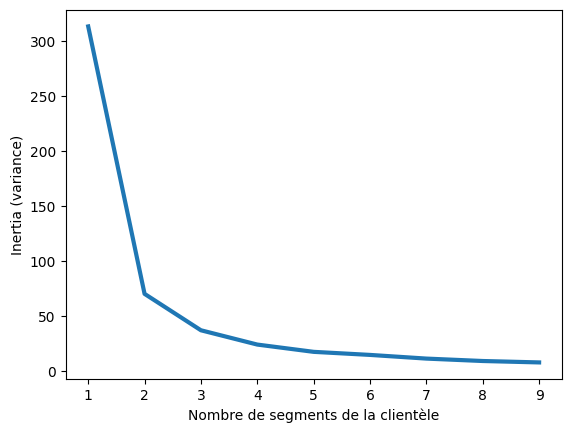

In [32]:
# Détermination du nombre de clusters

X = rfm_scaled[:, 1:]
k_range = range(1, 10)
k_inertias = []
 
for k in k_range:
    model = KMeans(n_clusters=k).fit(X)
    k_inertias.append(model.inertia_)
plt.plot(k_range , k_inertias , lw=3)
plt.xlabel('Nombre de segments de la clientèle')
plt.ylabel('Inertia (variance)')
plt.show()

Nous constations un nombre de clusters optimal égal à 3 car la pente devient très faible lorsque l'on dépasse 3 clusters

### Visualisation 3D de la clientèle segmentée

In [33]:
# Clustering avec le nombre de cluster maximal récupéré en haut
model = KMeans(n_clusters=3)
model.fit(X)
predictions = model.predict(X)

fig = go.Figure(data=[go.Scatter3d( 
    x= x.flatten(),
    y= y.flatten(),
    z= z.flatten(),
    mode='markers',
    marker=dict(
        size=5,
        color=predictions.flatten(),                
        colorscale=[
            [0.0, 'yellow'],
            [0.5, 'white'],
            [1.0, 'green']
        ],  
        opacity=0.8,
        reversescale=True
    )
)])

fig.update_layout(
    template="plotly_dark",
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Récence',
        yaxis_title='Fréquence',
        zaxis_title='Montant'
    )
)

fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

## Analyse des clusters sur les données non normalisées


In [34]:
# Préparation du tableau (résumant les clusters) pour l'analyse

rfm['cluster'] = model.fit_predict(rfm_scaled)

# Mini dataset regroupant les clusters
cluster_profile = rfm.groupby('cluster')[['récence', 'fréquence', 'montant']].mean().round(1)

#compter le nombre de clients par cluster
cluster_profile['Nb_clients'] = rfm.groupby('cluster').size()
cluster_profile = cluster_profile.reset_index()
cluster_profile

,cluster,récence,fréquence,montant,Nb_clients
0,0,46.2,111.7,2608.4,1686
1,1,49.2,102.1,1866.7,1693
2,2,262.6,27.3,566.6,888


Il ressort donc ici que les clients des segments 0 et 1 ont un comportement global presque similaire. Ceux du segment 2 ont un comportement très différent (les clients non reguliers, pas fidèles etc...)

Nous visualisons donc ci dessous le **comportement global de chaque profil de client** avec un **radar chart**.

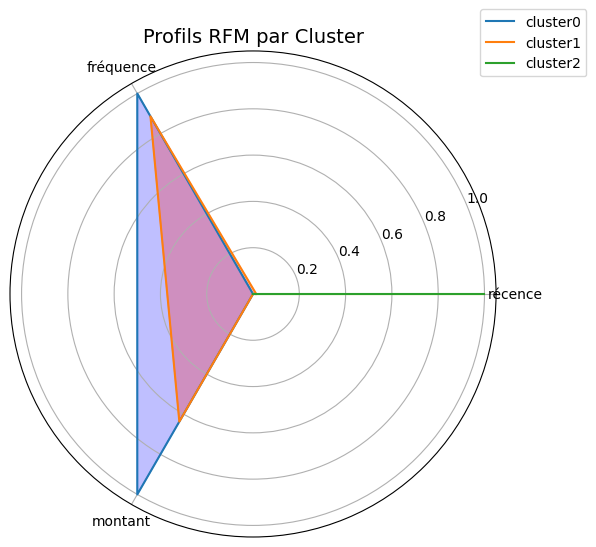

In [35]:
# visualisation avec radar chart

# Normalisation des moyennes pour comparaison sur le meme graphique
rfm_radar = cluster_profile[['récence', 'fréquence', 'montant']]
rfm_radar_scaled = scaler.fit_transform(rfm_radar)

# préparation pour le radar plot
labels = ['récence', 'fréquence', 'montant']
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# couleurs
colors = ['blue', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, row in enumerate(rfm_radar_scaled):
    values = row.tolist()
    values += angles[:1]
    ax.plot(angles, values, label=f'cluster{i}')
    ax.fill(angles, values, color = colors[i], alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Profils RFM par Cluster', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

## Anlayse, Conclusion et prise de décision

### Analyse du radar chart
Les axes représentent:
- **Récence**: plus la valeur est faible, plus le client est récent.
- **Fréquence**: nombre de commandes effectuées
- **montant**: total dépensé

On observe donc:
- **cluster0 (bleu)**:
    - **Très forte fréquence et très fort montant**.
    - **Faible récence** (clients récents)
    - **--> Ce sont nos meilleurs clients**: ils sont fidèles, actifs et à forte valeur.
- **cluster1 (orange)**:
    - **Bonne frequence, bon montant**, mais **legerement moins bon que cluster 0**
    - clients **assez recents** aussi
    - --> Ces clients sont **réguliers et rentables**, potentiellement en croissance.
- **cluster3 (vert)**:
    - **Tres mauvaise recence** (clients ancients/inactifs).
    - Frequence et montant **tres faibles**.
    - --> Ce sont des clients **perdus ou peu engagés**




## Conclusion et décisions stratégiques

### Cluster 0 (segment 0) 
-   **profil:** clients VIP/Loyaux
-   **Stratégie proposée:** Fidélisation renforcée (récompenses, offres exclusives, programme premium)

---

### Cluster 1 (segment 1)
-   **profil:** clients réguliers et actifs
-   **Stratégie proposée:** Incitation à consommer plus (up-sell, cross-sell, réductions ciblées)

---

### Cluster 2 (segment 2)
-   **profil:** clients inactis ou perdus
-   **Stratégie proposée:** Campagne de réactivation (emails, relance, promo de retour)